In [2]:
import pandas as pd
import numpy as np
from utils.utils import FrequencyProfile
from configparser import ConfigParser

import gurobipy as gp
from gurobipy import GRB

from simses.main import SimSES
from simses.commons.state.technology.lithium_ion import LithiumIonState

In [288]:
frequency = FrequencyProfile(pd.read_csv('Data/Frequency/fnew-2024-4.csv'))
frequency.add_response()

In [289]:
#convert dtm column into datetime format and make it the index
frequency['dtm'] = pd.to_datetime(frequency['dtm'])

In [290]:
from utils.utils import AuctionData
#get the auction prices for the given period
auction_data = AuctionData(pd.read_csv('Data/Frequency/FFR_clearing_price_23-24.csv'))
auction_data.rearrange()
auction_data['dtm'] = pd.to_datetime(auction_data['dtm'])

In [337]:
#simulation details
n = 1
start_date = pd.Timestamp('2024-04-11 23:00:00')

In [338]:
#input daily price data
epex_price_GBP_MWh = np.array([22, 7.35, -0.5, 7.25, 11.8,18.8,4.5,-4.5]*6*n)

In [339]:
#define battery parameters
capacity_MWh = 0.95*4.2
max_power_MW = 4

target_soc_max = 0.75
target_soc_min = 0.75

In [340]:
config_sim = ConfigParser()
config_opt = ConfigParser()
config_ana = ConfigParser()
config_ana.read('configs/analysis.optsim.ini')
config_opt.read('configs/optimization.optsim.ini')
config_sim.read('configs/simulation.optsim.ini')

['configs/simulation.optsim.ini']

In [328]:
auction_data_window.head()

auctionProduct,dtm,DC_high,DC_low,DM_high,DM_low,DR_high,DR_low
961,2024-04-11 02:00:00,5.77,0.87,6.31,2.64,5.84,7.94
962,2024-04-11 06:00:00,2.27,1.33,1.67,3.41,-0.88,8.50
963,2024-04-11 10:00:00,1.25,0.97,-0.98,3.07,-2.53,7.17
964,2024-04-11 14:00:00,2.40,1.84,1.72,4.04,-3.73,10.76
965,2024-04-11 18:00:00,3.45,4.00,1.11,6.96,-4.04,10.76


In [341]:
#initialize the simses model
simses = SimSES(path='results', name='test', simulation_config=config_sim, analysis_config=config_ana)

In [343]:
#initialize trackers
baseline = []
soc = []
power_demand_tracker = pd.DataFrame(columns=['frequency','power_demand'])
operation = []
payment_GBP = []
energy_cost_GBP = []
capacity_evolution = []

for day in range(0,n):
    day_start = start_date + pd.DateOffset(days=day)
    day_end = start_date + pd.DateOffset(days=day+1)
    daily_epex_price = epex_price_GBP_MWh[day*48:day*48+48]

    #extract the frequency data for the window
    frequency_window = frequency.loc[(frequency['dtm'] >= day_start) & (frequency['dtm'] < day_end)]
    auction_data_window = auction_data.loc[(auction_data['dtm'] >= day_start) & (auction_data['dtm'] < day_end)]

    #extract the clearing prices for the window
    clearing_prices = []
    for index, rows in auction_data_window.iterrows():
        for columns in auction_data_window.columns[1:]:
            clearing_prices.append(rows[columns])
    
    #run the optimization for the day
    print('Optimizing day', day+1, 'of', n, 'days.')
    print('target_soc_max:', target_soc_max)
    print('target_soc_min:', target_soc_min)
    capacity_allocation, target_soc_max_new,target_soc_min_new = optimize_day(frequency_window, clearing_prices, daily_epex_price, capacity_MWh, max_power_MW,target_soc_max,target_soc_min)
    
    print('target_soc_max_new:', target_soc_max_new)
    #bring the capacity allocations into the correct format
    daily_capacity_allocation_MW = {
            'DR_high': [],
            'DR_low': [],
            'DC_high': [],
            'DC_low': [],
            'DM_high': [],
            'DM_low': []
        }
    for i in range(0,6):
        daily_capacity_allocation_MW['DC_high'].append(capacity_allocation[6*i])
        daily_capacity_allocation_MW['DC_low'].append(capacity_allocation[6*i+1])
        daily_capacity_allocation_MW['DM_high'].append(capacity_allocation[6*i+2])
        daily_capacity_allocation_MW['DM_low'].append(capacity_allocation[6*i+3])
        daily_capacity_allocation_MW['DR_high'].append(capacity_allocation[6*i+4])
        daily_capacity_allocation_MW['DR_low'].append(capacity_allocation[6*i+5])
    
    print(daily_capacity_allocation_MW)

    #generate the corresponding powerdemand for the day
    power_demand = generate_power_demand(frequency.loc[(frequency['dtm'] >= day_start) & (frequency['dtm'] < day_end)], daily_capacity_allocation_MW)
    
    #run the daily battery simulation
    print('Simulating day', day+1, 'of', n, 'days.')
    fulfill2, soc2, capacity_after_run2, baseline_day = run_daily_battery_simulation_w_baseline(simses,power_demand,daily_capacity_allocation_MW)

    #calculate the payment for the day
    payment = sum(np.array(clearing_prices)*np.array(capacity_allocation))*4

    #calculate the energy cost for the day
    energy_cost = sum(np.array(daily_epex_price)*np.array(baseline_day)/1e6/2)

    #track the results
    baseline.append(baseline_day)
    soc.append(soc2)
    power_demand_tracker = pd.concat([power_demand_tracker, power_demand], axis = 0)
    payment_GBP.append(payment)
    energy_cost_GBP.append(energy_cost)
    operation.append(daily_capacity_allocation_MW)
    capacity_MWh = 0.95*capacity_after_run2/1e6
    capacity_evolution.append(capacity_after_run2)
    print('Target SOC max:', target_soc_max_new)
    target_soc_max = target_soc_max_new
    target_soc_min = target_soc_min_new

#output
print('In total, the battery made a revenue of ',sum(payment_GBP)-sum(energy_cost_GBP),' GBP.')
print('The battery got paid ',sum(payment_GBP),' GBP through FFR and paid ',sum(energy_cost_GBP),' GBP for the energy in baselines.')
print('The battery has a SOH of', capacity_evolution[-1]/4.2/1e6,'.')



Optimizing day 1 of 1 days.
target_soc_max: 0.75
target_soc_min: 0.75


KeyboardInterrupt: 

In [331]:
df_allocation = pd.DataFrame(operation)
df_allocation.head(10)

,DR_high,DR_low,DC_high,DC_low,DM_high,DM_low
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 2.99, 2.9899999999999998, 2.989999999999...","[3.9899999999999993, 3.999999999999999, 4.0, 4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 2.0200000000000005, 0.0]"
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 2.63652922846315, 1.954793842694726, 2.9...","[3.9873653346840725, 4.000000000000002, 4.0, 4...","[0.0, 1.3634707715368497, 0.0, 0.0, 1.36347077...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 2.045206157305274, 0.0, 0.0, 0.0]"
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 2.6288519407035373, 2.6288519407035373, ...","[3.994209312338122, 4.0, 4.0, 4.0, 4.0, 4.0]","[0.0, 1.3711480592964627, 1.3711480592964627, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 2.967515941825762, 2.967515941825762, 2....","[3.9958475443029347, 4.0, 4.0, 4.0, 3.99999999...","[4.0, 0.0, 0.0, 0.0, 0.0, 1.376645410898984]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 2.0649681163484757, 0.0]"
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 2.6193089953755715, 2.6193089953755715, ...","[3.9969409622155796, 4.0, 4.0, 4.0, 4.0, 4.0]","[4.0, 1.3806910046244283, 1.3806910046244283, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 2.0710365069366423, 2.071..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 2.615601250601583, 2.961700937951187, 2....","[3.9971942778317238, 4.0, 4.0, 4.0, 4.0, 4.0]","[4.0, 1.3843987493984173, 0.0, 1.3843987493984...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 2.076598124097626]"
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 2.6131695069324112, 2.959877130199308, 2...","[3.9975368103801325, 3.9975368103801348, 3.997...","[0.0, 1.3868304930675888, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.08147733441131677, 0.08..."


In [332]:
#calculate legal requirements for SOC
#calculate the min soc
min_soc = []
max_soc = []
for i in range(0,n):
    for j in range(0,6):
        min_soc.append((operation[i]['DR_low'][j]+operation[i]['DM_low'][j]*0.5+operation[i]['DC_low'][j]*0.25)/capacity_MWh)
        max_soc.append(1-(operation[i]['DR_high'][j]+operation[i]['DM_high'][j]*0.5+operation[i]['DC_high'][j]*0.25)/capacity_MWh)

In [333]:
print(min_soc)
print(max_soc)

[0.0, 0.7558225445351384, 0.7558225445351383, 0.7558225445351383, 0.7558225445351383, 0.7558225445351383, 0.0, 0.752636694710318, 0.7526366947103181, 0.7526366947103181, 0.7526366947103182, 0.7526366947103181, 0.0, 0.7511811761895156, 0.7511811761895156, 0.7511811761895156, 0.7511811761895156, 0.7511811761895156, 0.2527834597107486, 0.7501389465215167, 0.7501389465215167, 0.7501389465215167, 0.7501389465215167, 0.7501389465215167, 0.2527834597107486, 0.7493719521376402, 0.7493719521376402, 0.7493719521376402, 0.7493719521376403, 0.7493719521376403, 0.2527834597107486, 0.7486690097238704, 0.7486690097238703, 0.7486690097238704, 0.7486690097238704, 0.7486690097238703, 0.0, 0.7482079812905031, 0.748207981290503, 0.7482079812905029, 1.0008357776027432, 1.0008357776027434]
[0.7478484989385283, 0.7472165402892514, 0.7472165402892514, 0.7472165402892514, 0.7472165402892514, 0.7472165402892514, 0.7480149988919633, 0.7472165402892512, 0.7472165402892514, 0.7472165402892514, 0.7472165402892514, 

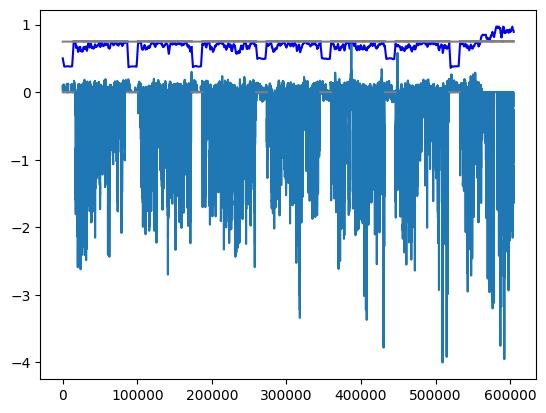

<Figure size 4000x1000 with 0 Axes>

In [334]:
#plot soc
import matplotlib.pyplot as plt
plt.plot(range(0,86400),soc[0],color='blue')
plt.plot(range(86400,86400*2),soc[1],color='blue')
plt.plot(range(86400*2,86400*3),soc[2],color='blue')
plt.plot(range(86400*3,86400*4),soc[3],color='blue')
plt.plot(range(86400*4,86400*5),soc[4],color='blue')
plt.plot(range(86400*5,86400*6),soc[5],color='blue')
plt.plot(range(86400*6,86400*7),soc[6],color='blue')

plt.plot(range(0,86400*7),power_demand_tracker['power_demand'])
    
#plot the legal requirements
for day in range(0,n):
    for i in range(0,6):
        plt.plot(range(day*86400+i*14400,day*86400+i*14400+14400),[min_soc[i]]*14400, color = 'grey')
        plt.plot(range(day*86400+i*14400,day*86400+i*14400+14400),[max_soc[i]]*14400, color = 'grey')

plt.figure(figsize=(40,10))

plt.show()

In [325]:
def optimize_day(df_window, clearing_prices, epex_price_GBP_MWh, capacity_MWh, max_power_MW,incoming_target_soc_max,incoming_target_soc_min):
    
    # Initialize the Gurobi model
    efficiency = 0.95
    no_of_cycles = 10000
    model = gp.Model("maximize_monetary_value")
    model.setParam('OutputFlag', 0)
    #Define decision variables for capacity allocations
    capacity_allocation = model.addVars(36, lb=0, ub=max_power_MW, name="capacity_allocation")

    cycle_count = model.addVar(lb=0.0, ub=100, vtype=GRB.CONTINUOUS, name="cycle_count")
    energy_usage_MWh = model.addVars(48, lb=-10, ub=10, vtype=GRB.CONTINUOUS, name="energy_usage")

    # Calculate cycle count based on df_window and capacity allocations
    cycle_count_expr = gp.LinExpr()
    energy_usage_expr = [gp.LinExpr() for _ in range(48)]

    window_start = df_window['dtm'].iloc[0]

    counter = 0
    #introduce target SOC requirements
    target_SOC_max = model.addVars(7, lb=0, ub=1, name="target_SOC_max")
    target_SOC_min = model.addVars(7, lb=0, ub=1, name="target_SOC_min")

    for index, row in df_window.iterrows():
        EAC_period = counter//14400
        power_with_sign = (row['DC_high']*capacity_allocation[EAC_period*6]*efficiency - row['DC_low']*capacity_allocation[EAC_period*6+1]/efficiency +
                        row['DM_high']*capacity_allocation[EAC_period*6+2]*efficiency - row['DM_low']*capacity_allocation[EAC_period*6+3]/efficiency +
                        row['DR_high']*capacity_allocation[EAC_period*6+4]*efficiency - row['DR_low']*capacity_allocation[EAC_period*6+5]/efficiency)
        
        power_wo_sign = (row['DC_high']*capacity_allocation[EAC_period*6]*efficiency + row['DC_low']*capacity_allocation[EAC_period*6+1]/efficiency +
                        row['DM_high']*capacity_allocation[EAC_period*6+2]*efficiency + row['DM_low']*capacity_allocation[EAC_period*6+3]/efficiency +
                        row['DR_high']*capacity_allocation[EAC_period*6+4]*efficiency + row['DR_low']*capacity_allocation[EAC_period*6+5]/efficiency)

        cycle_count_expr += power_wo_sign / 3600 / (2 * capacity_MWh)
        
        energy_MWh = power_with_sign / 3600

        # Calculate the half-hourly energy usage
        half_hour = int(np.floor((row['dtm'] - window_start).total_seconds() / 1800))
        energy_usage_expr[half_hour] += energy_MWh

    #convert the degradation into a monetary cost
    cyc_degradation = model.addVar(lb=0.0, ub=1, vtype=GRB.CONTINUOUS, name="cyc_degradation")

    aging_cost = cyc_degradation*400000*capacity_MWh

    #calculate the value of the energy received

    energy_value_GBP = model.addVar(lb=-1000, ub=1000, vtype=GRB.CONTINUOUS, name="energy_value_GBP")

    #calculate the payment from the frequency market
    payment = gp.quicksum(capacity_allocation[i] * clearing_prices[i] for i in range(len(capacity_allocation)))*4

    # Define the objective function to maximize monetary value
    monetary_value_GBP = payment - aging_cost + energy_value_GBP
    model.setObjective(monetary_value_GBP, GRB.MAXIMIZE)

    #-------------------CONSTRAINTS-------------------

    # Add a capacity constraints to make sure that the NESO regulation about delivery times are met

    for EAC_period in range(0,6):
        model.addConstr((capacity_allocation[6*EAC_period+0] + capacity_allocation[6*EAC_period+1]) * 0.25 + 
                        (capacity_allocation[6*EAC_period+2] + capacity_allocation[6*EAC_period+3]) * 0.5 + 
                        (capacity_allocation[6*EAC_period+4] + capacity_allocation[6*EAC_period+5])   <= capacity_MWh, f"capacity_limit_{EAC_period}")
        
        #add max and min target_SOC constraints
        model.addConstr(target_SOC_max[EAC_period+1] == 1-(capacity_allocation[6*EAC_period+0] * 0.25 + 
                        capacity_allocation[6*EAC_period+2] * 0.5 + 
                        capacity_allocation[6*EAC_period+4])/capacity_MWh, f"target_SOC_max_{EAC_period}")
        
        model.addConstr(target_SOC_min[EAC_period+1] == (capacity_allocation[6*EAC_period+1] * 0.25 + 
                        capacity_allocation[6*EAC_period+3] * 0.5 + 
                        capacity_allocation[6*EAC_period+5])/capacity_MWh, f"target_SOC_min_{EAC_period}")
    
    #add switching constraints
    model.addConstr(target_SOC_max[0] == incoming_target_soc_max, "target_SOC_max_0")
    model.addConstr(target_SOC_min[0] == incoming_target_soc_min, "target_SOC_min_0")

    for EAC_window in range(1,7):
        model.addConstr(target_SOC_min[EAC_window] <= target_SOC_max[EAC_window-1], f"target_SOC_max_{EAC_window}")
        model.addConstr(target_SOC_max[EAC_window] >= target_SOC_min[EAC_window-1], f"target_SOC_min_{EAC_window}")


    # Add a power constraint to ensure the batteries power limits are never exceeded
    #charging limit
    for EAC_window in range(0,6):
        model.addConstr(gp.quicksum(capacity_allocation[i] for i in np.linspace(6*EAC_window,6*EAC_window+4,3)) <= max_power_MW, f"power_limit_{EAC_window}")

        #discharging limit
        model.addConstr(gp.quicksum(capacity_allocation[i] for i in np.linspace(6*EAC_window+1,6*EAC_window+5,3)) <= max_power_MW, f"power_limit_{EAC_window}")

    # Add a constraint to define the cycling degradation
    model.addConstr(cyc_degradation == cycle_count/no_of_cycles, "cyc_degradation")

    #
    model.addConstr(energy_value_GBP == gp.quicksum(energy_usage_MWh[i] * epex_price_GBP_MWh[i] for i in range(48))*0.5, 'energy_value_GBP')

    # Add constraint to manage the energy usage
    for i in range(48):
        model.addConstr(energy_usage_MWh[i] == energy_usage_expr[i], f"energy_usage_{i}")

    # Add constraint to manage the number of cycles
    model.addConstr(cycle_count == cycle_count_expr, "cycle_count")


    # Optimize the model
    model.optimize()

    # Extract the optimal capacity allocations as well as target soc
    if model.status == GRB.OPTIMAL:
        optimal_allocations = model.getAttr('x', capacity_allocation)
        optimal_target_SOC_max = model.getAttr('x', target_SOC_max)
        optimal_target_SOC_min = model.getAttr('x', target_SOC_min)
    else:
        print("No optimal solution found")

    output_allocation = []
    output_target_SOC_max = []
    output_target_SOC_min = []
    for i in range(1,7):
        output_target_SOC_max.append(optimal_target_SOC_max[i])
        output_target_SOC_min.append(optimal_target_SOC_min[i])
        print('Target SOC max in function:', optimal_target_SOC_max[i])
    for i in range(36):
        output_allocation.append(optimal_allocations[i])

    return output_allocation,output_target_SOC_max[-1],output_target_SOC_min[-1]

In [60]:
def generate_power_demand(one_day_frequency, capacity_allocation):
        '''This functions generates the power demand for ONE DAY based on the frequency data and
        capacity allocations for that day'''
        
        # Initialize the power_demand DataFrame
        one_day_frequency.loc[:,'dtm'] = pd.to_datetime(one_day_frequency['dtm'])
        
        #make the dtm column the index
        one_day_frequency.set_index('dtm', inplace=True)
        power_demand = pd.DataFrame(index=one_day_frequency.index, columns=['frequency', 'power_demand',])        

        # Set the frequency column in one go
        power_demand['frequency'] = one_day_frequency['f']
        power_demand['power_demand'] = 0  # Initialize power_demand to 0
        
        for key in capacity_allocation.keys():
            # Determine the adjustment based on whether 'low' is in the key
            adjustment = -1 if 'low' in key else 1
            capacity_windows = capacity_allocation[key] # Convert to numpy array if not already
            
            # Calculate the hour block indices
            capacity_seconds = np.concatenate((np.ones(3600*4)*capacity_windows[0],np.ones(3600*4)*capacity_windows[1],np.ones(3600*4)*capacity_windows[2],
                                         np.ones(3600*4)*capacity_windows[3], np.ones(3600*4)*capacity_windows[4], np.ones(3600*4)*capacity_windows[5]),axis = 0)
            
            # Calculate the contribution for this key in a vectorized manner
            contribution = one_day_frequency[key].to_numpy() * capacity_seconds * adjustment
            
            # Add the contribution to the power_demand column
            power_demand['power_demand'] += contribution

        return power_demand

In [168]:
def run_daily_battery_simulation_w_baseline(simses, power_demand,allocations):
        '''
        This function runs the battery simulation for a single day and returns the resulting aging'''

        #initialize tracker
        power_sim_ac_delivered = np.zeros(86400)
        power_sim_ac_requested = np.zeros(86400)
        soc_sim = np.zeros(86400)
        fullfill = np.zeros(86400)
        sim_losses_charge = np.zeros(86400)
        sim_losses_discharge = np.zeros(86400)
        timestamps = power_demand.index.astype(int) / 10**9

        #initialize the baseline
        baseline = np.zeros(48)
        target_soc_list = []

        for half_hour in range(0,48):
            EAC_window_ref = min(5,(half_hour+1)//8)
            DC_high = allocations['DC_high'][EAC_window_ref]
            DC_low = allocations['DC_low'][EAC_window_ref]
            DM_high = allocations['DM_high'][EAC_window_ref]
            DM_low = allocations['DM_low'][EAC_window_ref]
            DR_high = allocations['DR_high'][EAC_window_ref]
            DR_low = allocations['DR_low'][EAC_window_ref]
        
            #calculate min and max energy requirements
            min_energy_Wh = (DC_low*0.25 + DM_low*0.5 + DR_low)*1e6
            max_energy_Wh = simses.state.capacity - (DC_high*0.25 + DM_high*0.5 + DR_high)*1e6


            #convert to soc
            min_soc = min_energy_Wh/simses.state.capacity
            max_soc = max_energy_Wh/simses.state.capacity

            #get target soc
            target_soc = (min_soc + max_soc)/2
            target_soc_list.append(target_soc)
            
            #calculate baseline
            if half_hour<=47:
                #get projected soc based on the baselines of the current and two upcoming periods
                projected_soc = simses.state.soc
                baseline[half_hour] = max(-4*1e6,min(4*1e6,(target_soc-projected_soc)*simses.state.capacity/0.5))

            for second in range(0,1800):
                simses.run_one_simulation_step(time = timestamps[half_hour*1800+second], 
                                               power = power_demand['power_demand'].iloc[half_hour*1800+second]*1e6 + baseline[half_hour])
                
                # track values from simses
                power_sim_ac_delivered[half_hour*1800+second] = simses.state.ac_power_delivered
                power_sim_ac_requested[half_hour*1800+second] = simses.state.ac_power
                soc_sim[half_hour*1800+second] = simses.state.soc
                fullfill[half_hour*1800+second] = simses.state.ac_fulfillment

                if simses.state.ac_power_delivered > 0:
                    sim_losses_charge[half_hour*1800+second] = simses.state.pe_losses + simses.state.dc_power_loss
                    sim_losses_discharge[half_hour*1800+second] = 0
                elif simses.state.ac_power_delivered < 0:
                    sim_losses_charge[half_hour*1800+second] = 0
                    sim_losses_discharge[half_hour*1800+second] = simses.state.pe_losses + simses.state.dc_power_loss
                else:
                    sim_losses_charge[half_hour*1800+second] = simses.state.pe_losses + simses.state.dc_power_loss
                    sim_losses_discharge[half_hour*1800+second] = simses.state.pe_losses + simses.state.dc_power_loss
            
        return np.mean(fullfill), soc_sim, simses.state.capacity, baseline